#### Beatriz Passoni Nunes 


## Importação do banco de dados
Durante esse processo, foram necessárias algumas modificações para garantir a compatibilidade com as funcionalidades da aplicação.
A única modificação feita foi a exclusão da coluna "status" da tabela pedidos, que não era utilizada na aplicação, foi removida. 

A seguir, estão os comandos SQL que implementam essas adaptações no Oracle.

In [ ]:
-- Create sequences
CREATE SEQUENCE categoria_id_seq START WITH 1 INCREMENT BY 1;
CREATE SEQUENCE subcategoria_id_seq START WITH 1 INCREMENT BY 1;
CREATE SEQUENCE produto_num_seq START WITH 1 INCREMENT BY 1;
CREATE SEQUENCE pedido_produto_id_seq START WITH 1 INCREMENT BY 1;

-- Create tables
CREATE TABLE categoria (
    id_categoria INT DEFAULT categoria_id_seq.NEXTVAL,
    nome VARCHAR2(50) NOT NULL,
    CONSTRAINT pk_categoria PRIMARY KEY (id_categoria),
    CONSTRAINT uk_categoria_nome UNIQUE (nome)
);

CREATE TABLE subcategoria (
    id_subcategoria INT DEFAULT subcategoria_id_seq.NEXTVAL,
    nome VARCHAR2(50) NOT NULL,
    id_categoria INT,
    CONSTRAINT pk_subcategoria PRIMARY KEY (id_subcategoria),
    CONSTRAINT fk_categoria_id FOREIGN KEY (id_categoria)
        REFERENCES categoria (id_categoria) ON DELETE CASCADE
);

CREATE TABLE produto (
    num INT DEFAULT produto_num_seq.NEXTVAL,
    nome VARCHAR2(50) NOT NULL,
    preco NUMBER(10, 2) NOT NULL,
    descricao VARCHAR2(1000),
    estoque INT NOT NULL,
    id_subcategoria INT NOT NULL,
    CONSTRAINT pk_produto PRIMARY KEY (num),
    CONSTRAINT fk_subcategoria_id FOREIGN KEY (id_subcategoria)
        REFERENCES subcategoria (id_subcategoria) ON DELETE CASCADE
);

CREATE TABLE cliente (
    nome VARCHAR2(50) NOT NULL,
    sobrenome VARCHAR2(100) NOT NULL,
    sexo CHAR(1),
    data_nascimento DATE NOT NULL,
    cpf CHAR(14) NOT NULL,
    email VARCHAR2(80) NOT NULL,
    senha VARCHAR2(30) NOT NULL,
    CONSTRAINT pk_cliente PRIMARY KEY (cpf),
    CONSTRAINT uk_cliente_email UNIQUE (email),
    CONSTRAINT ck_cliente_sexo CHECK (sexo IN ('M', 'F')),
    CONSTRAINT ck_cliente_cpf CHECK (REGEXP_LIKE(cpf, '^\d{3}\.\d{3}\.\d{3}-\d{2}$'))
);

CREATE TABLE pedido (
    nota_fiscal CHAR(14) NOT NULL,
    cpf_cliente CHAR(14) NOT NULL,
    data_pedido DATE NOT NULL,
    hora_pedido TIMESTAMP NOT NULL,
    CONSTRAINT pk_pedido PRIMARY KEY (nota_fiscal),
    CONSTRAINT fk_cliente_id FOREIGN KEY (cpf_cliente)
        REFERENCES cliente (cpf) ON DELETE CASCADE
);

CREATE TABLE pedido_produto (
    id INT DEFAULT pedido_produto_id_seq.NEXTVAL,
    qnt_produto INT NOT NULL,
    nf_pedido CHAR(14) NOT NULL,
    num_produto INT NOT NULL,
    CONSTRAINT pk_pedido_produto PRIMARY KEY (id),
    CONSTRAINT fk_pedido_nf FOREIGN KEY (nf_pedido)
        REFERENCES pedido (nota_fiscal) ON DELETE CASCADE,
    CONSTRAINT fk_produto_num FOREIGN KEY (num_produto)
        REFERENCES produto (num) ON DELETE CASCADE,
    CONSTRAINT ck_qnt_produto CHECK (qnt_produto > 0)
);

## Carga das tabelas do banco de dados
O procedimento carga_dados insere dados nas tabelas de categorias, subcategorias, produtos, clientes, pedidos e itens de pedidos. Ele utiliza o parâmetro fator_escala para ajustar a quantidade de dados inseridos. O código gera informações aleatórias, como preços, estoques, datas e CPFs, escalando a inserção conforme o valor de fator_escala, permitindo simulações com diferentes volumes de dados. Ao final, os dados são confirmados com um COMMIT.

In [ ]:
CREATE OR REPLACE PROCEDURE carga_dados(fator_escala IN NUMBER) AS
BEGIN
    -- Carregar categorias
    FOR i IN 1..(4 * fator_escala) LOOP
        INSERT INTO categoria (nome)
        VALUES ('Categoria ' || i);
    END LOOP;

    -- Carregar subcategorias
    FOR i IN 1..(10 * fator_escala) LOOP
        INSERT INTO subcategoria (nome, id_categoria)
        VALUES ('Subcategoria ' || i, MOD(i - 1, (4 * fator_escala)) + 1);
    END LOOP;

    -- Carregar produtos
    FOR i IN 1..(20 * fator_escala) LOOP
        INSERT INTO produto (nome, preco, descricao, estoque, id_subcategoria)
        VALUES (
            'Produto ' || i,
            ROUND(DBMS_RANDOM.VALUE(10, 500), 2), -- Preço aleatório entre 10 e 500
            'Descrição do Produto ' || i,
            TRUNC(DBMS_RANDOM.VALUE(1, 100)), -- Estoque aleatório entre 1 e 100
            MOD(i - 1, (10 * fator_escala)) + 1 -- Subcategoria aleatória
        );
    END LOOP;

    -- Carregar clientes
    FOR i IN 1..(5 * fator_escala) LOOP
        -- Gerar CPF diretamente no formato correto
        DECLARE
            cpf_formatado CHAR(14);
        BEGIN
            -- Gerar os primeiros 9 dígitos do CPF
            cpf_formatado := LPAD(TRUNC(DBMS_RANDOM.VALUE(100000000, 999999999)), 9, '0');
            -- Formatá-lo como XXX.XXX.XXX-XX
            cpf_formatado := SUBSTR(cpf_formatado, 1, 3) || '.' || 
                             SUBSTR(cpf_formatado, 4, 3) || '.' || 
                             SUBSTR(cpf_formatado, 7, 3) || '-' || 
                             LPAD(TRUNC(DBMS_RANDOM.VALUE(0, 99)), 2, '0');

            -- Inserir cliente com CPF formatado
            INSERT INTO cliente (nome, sobrenome, sexo, data_nascimento, cpf, email, senha)
            VALUES (
                'Cliente' || i,
                'Sobrenome' || i,
                CASE MOD(i, 2) WHEN 0 THEN 'M' ELSE 'F' END,
                TRUNC(TO_DATE('1930-01-01', 'YYYY-MM-DD') + DBMS_RANDOM.VALUE(0, 31046)), -- Data entre 1930 e 2015
                cpf_formatado,
                'cliente' || i || '@exemplo.com',
                'Senha' || i
            );
        END;
    END LOOP;

    -- Carregar pedidos
    FOR i IN 1..(10 * fator_escala) LOOP
        INSERT INTO pedido (nota_fiscal, cpf_cliente, data_pedido, hora_pedido)
        VALUES (
            LPAD(i, 14, '0'),
            (SELECT cpf FROM (SELECT cpf FROM cliente ORDER BY DBMS_RANDOM.VALUE) WHERE ROWNUM = 1), -- Cliente aleatório
            TRUNC(SYSDATE - DBMS_RANDOM.VALUE(1, 365)), -- Data aleatória no último ano
            SYSDATE - DBMS_RANDOM.VALUE(0, 1) -- Hora aleatória no último dia
        );
    END LOOP;

    -- Carregar itens de pedidos
    FOR i IN 1..(30 * fator_escala) LOOP
        INSERT INTO pedido_produto (qnt_produto, nf_pedido, num_produto)
        VALUES (
            TRUNC(DBMS_RANDOM.VALUE(1, 10)), -- Quantidade aleatória entre 1 e 10
            (SELECT nota_fiscal FROM (SELECT nota_fiscal FROM pedido ORDER BY DBMS_RANDOM.VALUE) WHERE ROWNUM = 1), -- Pedido aleatório
            (SELECT num FROM (SELECT num FROM produto ORDER BY DBMS_RANDOM.VALUE) WHERE ROWNUM = 1) -- Produto aleatório
        );
    END LOOP;

    COMMIT;
END;
/
SHOW ERRORS;

BEGIN
    carga_dados(2); -- Fator de escala 2
END;
/

## Views

#### View Computada

A view vw_total_pedidos exibe o total de pedidos realizados por cada cliente, junto com a soma do valor total dos pedidos. Ela utiliza as tabelas cliente, pedido, pedido_produto e produto, realizando junções para obter as informações necessárias. O valor total é calculado multiplicando a quantidade de cada produto pelo seu preço, e o NVL é utilizado para garantir que, caso não haja produtos, o valor total seja zero. O resultado é agrupado por cliente, ordenado pelo valor total em ordem decrescente.


In [ ]:
-- Apresenta o total de pedidos realizados por cada cliente, incluindo a soma do valor total dos pedidos.
CREATE OR REPLACE VIEW vw_total_pedidos AS
SELECT 
    c.nome || ' ' || c.sobrenome AS cliente_nome,
    c.cpf AS cliente_cpf,
    COUNT(p.nota_fiscal) AS total_pedidos,
    NVL(SUM(pp.qnt_produto * pr.preco), 0) AS valor_total
FROM 
    cliente c
LEFT JOIN 
    pedido p ON c.cpf = p.cpf_cliente
LEFT JOIN 
    pedido_produto pp ON p.nota_fiscal = pp.nf_pedido
LEFT JOIN 
    produto pr ON pp.num_produto = pr.num
GROUP BY 
    c.nome, c.sobrenome, c.cpf;
 
SELECT * FROM vw_total_pedidos ORDER BY valor_total DESC;

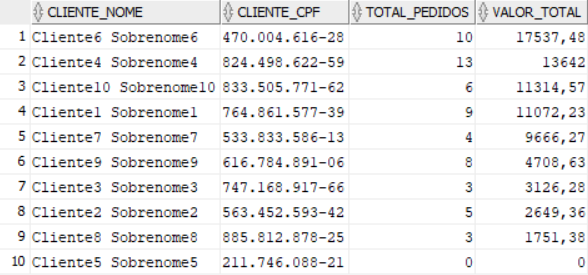

#### View Materializada

A view materializada mv_estoque_faturamento_categoria calcula o estoque total e o faturamento potencial de cada categoria de produto. Ela é criada de forma imediata (BUILD IMMEDIATE) e configurada para ser atualizada sob demanda (REFRESH COMPLETE ON DEMAND). Quando há alterações nas tabelas subjacentes, é necessário realizar um refresco manual da view materializada, utilizando o comando DBMS_MVIEW.REFRESH, para garantir que os dados de estoque e faturamento sejam recalculados corretamente.

In [ ]:
-- Criação da visão materializada
CREATE MATERIALIZED VIEW mv_estoque_faturamento_categoria
BUILD IMMEDIATE
REFRESH COMPLETE ON DEMAND
AS
SELECT 
    cat.nome AS categoria_nome,
    SUM(prod.estoque) AS total_estoque,
    SUM(prod.estoque * prod.preco) AS faturamento_potencial
FROM 
    categoria cat
LEFT JOIN 
    subcategoria sub ON cat.id_categoria = sub.id_categoria
LEFT JOIN 
    produto prod ON sub.id_subcategoria = prod.id_subcategoria
GROUP BY 
    cat.nome;

SELECT * FROM mv_estoque_faturamento_categoria
ORDER BY  faturamento_potencial DESC; 


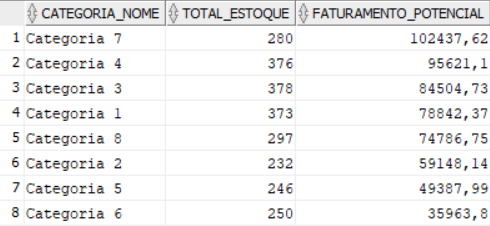

Foram realizadas atualizações nos produtos das subcategorias 1 e 2, ajustando os valores de estoque e preço. Após essas atualizações, a view materializada foi atualizada manualmente com o comando DBMS_MVIEW.REFRESH, garantindo que os cálculos de estoque e faturamento fossem corrigidos de acordo com as mudanças feitas nas tabelas de produtos.

In [ ]:
-- Atualização de produtos
UPDATE produto
SET estoque = estoque + 50, -- Incrementa o estoque
    preco = preco * 1.10    -- Aumenta o preço em 10%
WHERE 
    id_subcategoria = 1;    -- Subcategoria específica

-- Atualizar outra subcategoria para mais exemplos
UPDATE produto
SET estoque = estoque - 10
WHERE id_subcategoria = 2;

-- Refresh da visão materializada
BEGIN
    DBMS_MVIEW.REFRESH('mv_estoque_faturamento_categoria', 'C');
END;
/
-- Consulta à visão materializada
SELECT 
    categoria_nome,
    total_estoque,
    faturamento_potencial
FROM 
    mv_estoque_faturamento_categoria
ORDER BY 
    faturamento_potencial DESC;

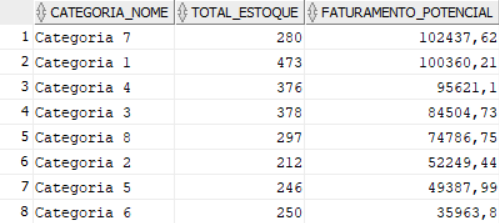

## Common Table Expressions (CTE)

#### CTE (Não Recursiva)

A CTE não recursiva vendas_totais calcula o total de vendas de cada produto, utilizando as tabelas produto e pedido_produto. Para cada produto, é realizada uma soma do valor total de vendas, considerando a quantidade (qnt_produto) e o preço (preco). O resultado é agrupado por produto e ordenado de forma decrescente pelo total de vendas, com a condição de que o total de vendas seja superior a 3000. A consulta final retorna os produtos com maior volume de vendas.



In [ ]:
WITH vendas_totais AS (
    SELECT 
        pr.num AS produto_id,
        pr.nome AS produto_nome,
        SUM(pp.qnt_produto * pr.preco) AS total_vendas
    FROM 
        produto pr
    JOIN 
        pedido_produto pp ON pr.num = pp.num_produto
    GROUP BY 
        pr.num, pr.nome
)
SELECT 
    produto_id, 
    produto_nome, 
    total_vendas
FROM 
    vendas_totais
WHERE 
    total_vendas > 3000
ORDER BY 
    total_vendas DESC;


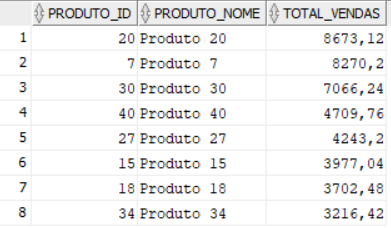

#### CTE Recursiva

A CTE recursiva produto_hierarquia é utilizada para gerar uma hierarquia de categorias e subcategorias de produtos, com a contagem de produtos em cada subcategoria. 

Composta por duas partes:

Parte Âncora: A primeira parte da CTE seleciona as categorias, atribuindo o nível 1, sem produtos diretamente associados, e inicializa a contagem de produtos (total_produtos) como zero. <br>
Parte Recursiva: A segunda parte adiciona as subcategorias à hierarquia, associando-as às categorias correspondentes. Para cada subcategoria, é realizada uma contagem dos produtos que pertencem a ela. A recursividade é garantida pela cláusula UNION ALL, que liga as subcategorias às categorias e permite que a consulta expanda hierarquicamente.

O resultado final da CTE exibe a hierarquia completa, com categorias e subcategorias, o nível de cada item na hierarquia, o identificador e o nome, além da contagem de produtos em cada subcategoria. A consulta final retorna os dados ordenados por nível e pela estrutura hierárquica.

In [ ]:
WITH produto_hierarquia (nivel, id, nome, tipo, id_pai, total_produtos) AS (
    -- Parte âncora: Categorias (nível 1, sem produtos diretamente associados)
    SELECT 
        1 AS nivel,
        c.id_categoria AS id,
        c.nome AS nome,
        'Categoria' AS tipo,
        NULL AS id_pai,
        0 AS total_produtos
    FROM categoria c

    UNION ALL

    -- Parte recursiva: Subcategorias (nível 2, associadas às categorias) com contagem de produtos
    SELECT 
        ph.nivel + 1 AS nivel,
        s.id_subcategoria AS id,
        s.nome AS nome,
        'Subcategoria' AS tipo,
        ph.id AS id_pai,
        (SELECT COUNT(*) 
         FROM produto p 
         WHERE p.id_subcategoria = s.id_subcategoria) AS total_produtos
    FROM subcategoria s
    JOIN produto_hierarquia ph ON s.id_categoria = ph.id
    AND ph.tipo = 'Categoria' -- Garante que subcategorias sejam ligadas apenas a categorias
)
SELECT nivel, id, nome, tipo, id_pai, total_produtos
FROM produto_hierarquia
ORDER BY nivel, id_pai, id;

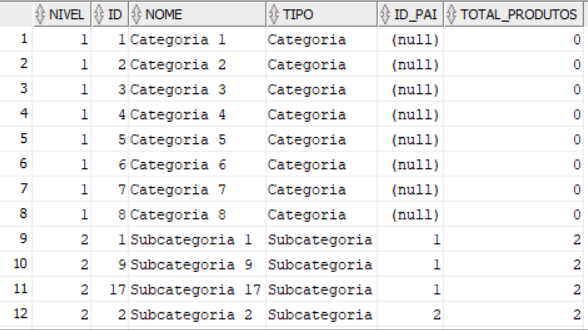

## Window Functions

##### Consulta 1: Ranking dos Clientes pelo Valor Total dos Pedidos
Nesta consulta, a função de janela RANK() é utilizada para classificar os clientes de acordo com o valor total dos pedidos realizados. A consulta calcula o total de pedidos e o valor total gasto por cada cliente, utilizando as tabelas cliente, pedido, pedido_produto e produto. A função RANK() atribui uma posição de ranking a cada cliente, ordenando-os pelo valor total de vendas em ordem decrescente. O resultado é uma lista de clientes, seu total de pedidos, valor total e ranking.

In [ ]:
-- Consulta 1: Ranking dos Clientes pelo Valor Total dos Pedidos
SELECT 
    c.nome || ' ' || c.sobrenome AS cliente_nome,
    c.cpf AS cliente_cpf,
    COUNT(p.nota_fiscal) AS total_pedidos,
    NVL(SUM(pp.qnt_produto * pr.preco), 0) AS valor_total,
    RANK() OVER (ORDER BY NVL(SUM(pp.qnt_produto * pr.preco), 0) DESC) AS ranking
FROM 
    cliente c
LEFT JOIN 
    pedido p ON c.cpf = p.cpf_cliente
LEFT JOIN 
    pedido_produto pp ON p.nota_fiscal = pp.nf_pedido
LEFT JOIN 
    produto pr ON pp.num_produto = pr.num
GROUP BY 
    c.nome, c.sobrenome, c.cpf
ORDER BY 
    ranking;

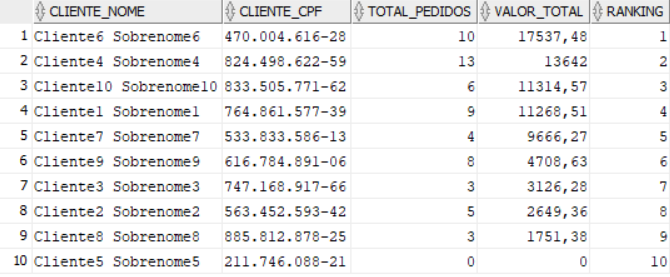

##### Consulta 2: Participação de Cada Categoria no Estoque Total 
A segunda consulta utiliza a função de janela SUM() OVER () para calcular a participação de cada categoria no estoque total. Ela soma o estoque de cada produto nas categorias e calcula o percentual do estoque de cada categoria em relação ao estoque total. A função SUM() OVER () realiza a soma do estoque total, permitindo o cálculo do percentual de cada categoria. O resultado exibe as categorias e sua participação proporcional no estoque, ordenado pelo percentual de maior para menor.

In [ ]:
-- Consulta 2: Participação de Cada Categoria no Estoque Total
SELECT 
    c.nome AS categoria_nome,
    SUM(pr.estoque) AS estoque_categoria,
    ROUND(SUM(pr.estoque) * 100.0 / SUM(SUM(pr.estoque)) OVER (), 2) AS percentual_estoque
FROM 
    categoria c
JOIN 
    subcategoria s ON c.id_categoria = s.id_categoria
JOIN 
    produto pr ON s.id_subcategoria = pr.id_subcategoria
GROUP BY 
    c.nome
ORDER BY 
    percentual_estoque DESC;


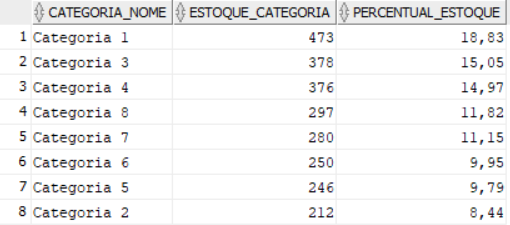

## Função SQL

Função SQL: calcula_desconto_cliente
A função calcula_desconto_cliente calcula o valor total dos pedidos de um cliente e aplica um desconto sobre esse valor. Ela recebe dois parâmetros: o CPF do cliente (p_cpf_cliente) e a taxa de desconto (p_taxa_desconto). A função calcula o valor total dos pedidos do cliente, utilizando as tabelas pedido, pedido_produto e produto, somando o valor de cada produto (quantidade * preço). Em seguida, o desconto é aplicado ao valor total, e o resultado com o desconto é retornado. Se não houver pedidos, a função retorna 0.

In [ ]:
-- Implementação da função SQL
CREATE OR REPLACE FUNCTION calcula_desconto_cliente(
    p_cpf_cliente IN CHAR,
    p_taxa_desconto IN NUMBER
) RETURN NUMBER IS
    v_valor_total NUMBER;
BEGIN
    -- Calcula o valor total dos pedidos do cliente
    SELECT NVL(SUM(pp.qnt_produto * pr.preco), 0)
    INTO v_valor_total
    FROM pedido p
    JOIN pedido_produto pp ON p.nota_fiscal = pp.nf_pedido
    JOIN produto pr ON pp.num_produto = pr.num
    WHERE p.cpf_cliente = p_cpf_cliente;

    -- Retorna o valor total com desconto aplicado
    RETURN v_valor_total * (1 - p_taxa_desconto / 100);
END;
/

##### Consulta que invoca a função
A consulta invoca a função calcula_desconto_cliente para calcular o valor total com desconto de cada cliente, considerando uma taxa de 15%. Ela retorna o nome do cliente, CPF, valor total dos pedidos, valor com o desconto aplicado, e a elegibilidade do cliente para o status "VIP" (clientes com valor com desconto superior a 1000 são considerados VIPs). A consulta também filtra os clientes com um valor total de pedidos superior a 500 (após o desconto), utilizando a cláusula HAVING. O resultado é ordenado pelo valor com desconto em ordem decrescente.

In [ ]:
SELECT 
    c.nome || ' ' || c.sobrenome AS cliente_nome,
    c.cpf AS cliente_cpf,
    NVL(SUM(pp.qnt_produto * pr.preco), 0) AS valor_total_pedidos,
    calcula_desconto_cliente(c.cpf, 15) AS valor_com_desconto, -- Aplica 15% de desconto
    CASE 
        WHEN calcula_desconto_cliente(c.cpf, 15) > 1000 THEN 'Elegível para VIP'
        ELSE 'Sem Benefício'
    END AS status_cliente
FROM 
    cliente c
LEFT JOIN 
    pedido p ON c.cpf = p.cpf_cliente
LEFT JOIN 
    pedido_produto pp ON p.nota_fiscal = pp.nf_pedido
LEFT JOIN 
    produto pr ON pp.num_produto = pr.num
GROUP BY 
    c.nome, c.sobrenome, c.cpf
HAVING 
    calcula_desconto_cliente(c.cpf, 15) > 500 -- Filtra clientes com pedidos significativos (acima de R$ 500)
ORDER BY 
    valor_com_desconto DESC;


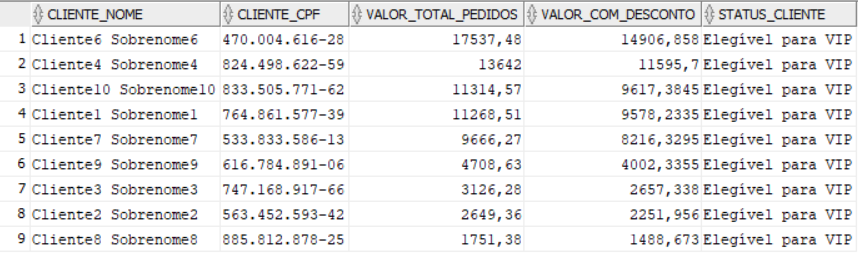

## Trigger DML

#### Trigger DML
A trigger trg_log_produto é configurada para ser acionada após a atualização do campo preço na tabela produto. Sempre que o preço de um produto for atualizado, a trigger registra a alteração na tabela de log log_produto. Ela insere informações como o número do produto, a ação realizada (atualização de preço), o valor antigo e o valor novo do preço, além de registrar a data e hora da operação. Isso permite acompanhar e auditar as mudanças no preço dos produtos.

In [ ]:
-- Tabela de log
CREATE TABLE log_produto (
    id_log INT GENERATED ALWAYS AS IDENTITY PRIMARY KEY,
    num_produto INT NOT NULL,
    acao VARCHAR2(50) NOT NULL,
    valor_antigo NUMBER(10, 2),
    valor_novo NUMBER(10, 2),
    data_hora TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

In [ ]:
-- Trigger de log para atualizações na tabela produto
CREATE OR REPLACE TRIGGER trg_log_produto
AFTER UPDATE OF preco ON produto
FOR EACH ROW
BEGIN
    INSERT INTO log_produto (num_produto, acao, valor_antigo, valor_novo)
    VALUES (:OLD.num, 'Atualização de Preço', :OLD.preco, :NEW.preco);
END;
/

##### Teste do trigger 

In [ ]:
-- Atualizar um produto para disparar o trigger
UPDATE produto
SET preco = preco * 1.2
WHERE num = 1;

-- Consultar o log para verificar as atualizações
SELECT * FROM log_produto;

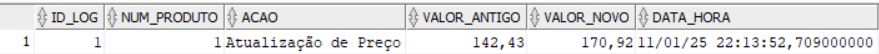

#### Trigger Restrição de Integridade

A trigger trg_verifica_estoque é acionada antes de inserir ou atualizar um registro na tabela pedido_produto. Seu objetivo é garantir que a quantidade de produtos no pedido não ultrapasse o estoque disponível. A trigger verifica o estoque atual do produto e a quantidade já solicitada no pedido, somando a nova quantidade. Se a quantidade total exceder o estoque, a trigger gera uma exceção (RAISE_APPLICATION_ERROR), impedindo a inserção ou atualização. Caso contrário, a operação é permitida. Isso garante a integridade do estoque durante a manipulação dos pedidos.

In [ ]:
-- Trigger para garantir que a quantidade de produtos não ultrapasse o estoque
CREATE OR REPLACE TRIGGER trg_verifica_estoque
BEFORE INSERT OR UPDATE ON pedido_produto
FOR EACH ROW
DECLARE
    v_estoque_disponivel INT;
    v_quantidade_total INT;
BEGIN
    -- Verifica o estoque disponível
    SELECT estoque INTO v_estoque_disponivel
    FROM produto
    WHERE num = :NEW.num_produto;

    -- Soma a quantidade de produtos já presente no pedido
    SELECT NVL(SUM(qnt_produto), 0)
    INTO v_quantidade_total
    FROM pedido_produto
    WHERE num_produto = :NEW.num_produto;

    -- Adiciona a nova quantidade do produto
    v_quantidade_total := v_quantidade_total + :NEW.qnt_produto;

    -- Lança exceção se ultrapassar o estoque
    IF v_quantidade_total > v_estoque_disponivel THEN
        RAISE_APPLICATION_ERROR(-20001, 'Quantidade de produtos excede o estoque disponível.');
    END IF;
END;
/

##### Teste de trigger

In [ ]:
-- Inserção válida (estoque suficiente)
INSERT INTO pedido_produto (qnt_produto, nf_pedido, num_produto)
VALUES (5, '00000000000001', 1);

-- Inserção inválida (estoque insuficiente)
INSERT INTO pedido_produto (qnt_produto, nf_pedido, num_produto)
VALUES (500, '00000000000001', 1); -- Deve disparar uma exceção

Saída da inserção inválida

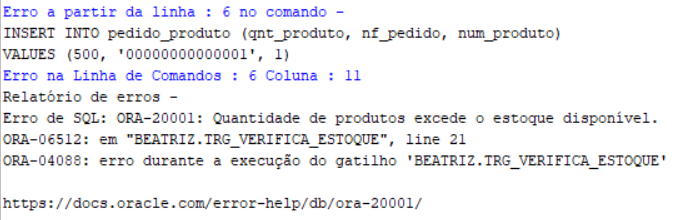

Consultar o log de alterações de preço


In [ ]:
SELECT * FROM log_produto;

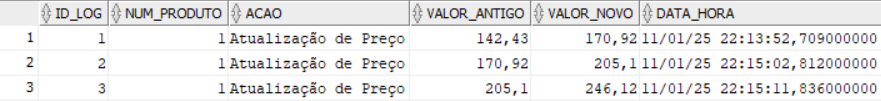